# Research topic: Bankruptcy prediction using big data techniques

In the era of massive information flow, big data techniques have emerged as a game-changing approach to handling and deriving value from vast and complex datasets. These techniques involve innovative tools like distributed computing, parallel processing, and machine learning to process, analyze, and extract insights from data that surpasses traditional processing capacities. With a focus on the three key dimensions of volume, velocity, and variety, big data techniques offer the potential to uncover hidden patterns, predict trends, and inform decision-making across various sectors and industries. 

In this notebook, we will look forward for spark implementation bankrucptcy predcition techniques using Taiwanese and American dataset.

lets begin

# Importing the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


import warnings
warnings.filterwarnings(action="ignore")


from imblearn.over_sampling import SMOTE



from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report, f1_score

from sklearn.decomposition import PCA
import plotly.express as px

# spark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# IMPORTING DATA

# taiwan data 
atbank_data = pd.read_csv('atcollabed_data.csv')


In [3]:
# Print First 5 records of Taiwan data
atbank_data.head()

Bankrupt?   Operating Gross Margin   Pre-tax net Interest Rate   
0          1                 0.601457                    0.796887  \
1          1                 0.610235                    0.797380   
2          1                 0.601450                    0.796403   
3          1                 0.583541                    0.796967   
4          1                 0.598783                    0.797366   

    After-tax net Interest Rate   Operating Expense Rate   Current Ratio   
0                      0.808809             1.256970e-04        0.002259  \
1                      0.809301             2.897850e-04        0.006016   
2                      0.808388             2.361300e-04        0.011543   
3                      0.808966             1.078890e-04        0.004194   
4                      0.809304             7.890000e+09        0.006022   

    Operating profit/Paid-in capital   Net profit before tax/Paid-in capital   
0                           0.095885                                0.137757  \
1                           0.093743                                0.168962   
2                           0.092318                                0.148036   
3                           0.077727                                0.147561   
4                           0.096927                                0.167461   

    Total debt/Total net worth   Debt ratio %   Net worth/Assets   
0                     0.021266       0.207576           0.792424  \
1                     0.012502       0.171176           0.828824   
2                     0.021248       0.207516           0.792484   
3                     0.009572       0.151465           0.848535   
4                     0.005150       0.106509           0.893491   

    Current Assets/Total Assets   Current Liability to Assets   
0                      0.190643                      0.147308  \
1                      0.182419                      0.056963   
2                      0.602806                      0.098162   
3                      0.225815                      0.098715   
4                      0.358380                      0.110195   

    Current Liabilities/Liability   Current Liabilities/Equity   
0                        0.676269                     0.339077  \
1                        0.308589                     0.329740   
2                        0.446027                     0.334777   
3                        0.615848                     0.331509   
4                        0.975007                     0.330726   

    Long-term Liability to Current Assets   Retained Earnings to Total Assets   
0                                0.025592                            0.903225  \
1                                0.023947                            0.931065   
2                                0.003715                            0.909903   
3                                0.022165                            0.906902   
4                                0.000000                            0.913850   

    Net Income to Total Assets   Liability to Equity   Equity to Liability  
0                     0.716845              0.290202              0.016469  
1                     0.795297              0.283846              0.020794  
2                     0.774670              0.290189              0.016474  
3                     0.739555              0.281721              0.023982  
4                     0.795016              0.278514              0.035490

In [4]:
# The classes are heavily skewed we need to solve this issue later.
# count of bankrupt and non-bankrupt companies

print(atbank_data['Bankrupt?'].value_counts())
print('-'* 30)
print('Non-Bankrupt: ', round(atbank_data['Bankrupt?'].value_counts()[0]/len(atbank_data) * 100,2), '% of the dataset')
print('Bankrupt: ', round(atbank_data['Bankrupt?'].value_counts()[1]/len(atbank_data) * 100,2), '% of the dataset')

Bankrupt?
0    10108
1      454
Name: count, dtype: int64
------------------------------
Non-Bankrupt:  95.7 % of the dataset
Bankrupt:  4.3 % of the dataset


# Exploratory data analaysis [ EDA ]

In [5]:
atbank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10562 entries, 0 to 10561
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Bankrupt?                               10562 non-null  int64  
 1    Operating Gross Margin                 10562 non-null  float64
 2    Pre-tax net Interest Rate              10562 non-null  float64
 3    After-tax net Interest Rate            10562 non-null  float64
 4    Operating Expense Rate                 10562 non-null  float64
 5    Current Ratio                          10562 non-null  float64
 6    Operating profit/Paid-in capital       10562 non-null  float64
 7    Net profit before tax/Paid-in capital  10562 non-null  float64
 8    Total debt/Total net worth             10562 non-null  float64
 9    Debt ratio %                           10562 non-null  float64
 10   Net worth/Assets                       10562 non-null  fl

In [6]:
# checking for duplicate values
atbank_data.duplicated().sum()

0

In [7]:
atbank_data.describe()

Bankrupt?   Operating Gross Margin   Pre-tax net Interest Rate   
count  10562.000000             10562.000000                10562.000000  \
mean       0.042984                 0.426503                    0.349445   
std        0.202831                 2.346536                    4.837422   
min        0.000000              -120.770115                 -384.000000   
25%        0.000000                 0.411898                    0.114833   
50%        0.000000                 0.600787                    0.797377   
75%        0.000000                 0.610185                    0.797505   
max        1.000000                 6.600000                    6.600000   

        After-tax net Interest Rate   Operating Expense Rate   Current Ratio   
count                  10562.000000             1.056200e+04    1.056200e+04  \
mean                       0.358363             1.288229e+09    2.603681e+05   
std                        7.188296             2.770993e+09    2.675837e+07   
min                     -394.000000            -5.600000e+00    0.000000e+00   
25%                        0.071245             2.030580e-04    9.127897e-03   
50%                        0.809307             7.984482e-01    1.727889e-02   
75%                        0.809410             1.027090e+00    5.441362e-01   
max                      288.500000             9.990000e+09    2.750000e+09   

        Operating profit/Paid-in capital   
count                       10562.000000  \
mean                           -0.339441   
std                            18.953186   
min                         -1055.000000   
25%                            -0.442760   
50%                             0.095950   
75%                             0.109267   
max                          1498.500000   

        Net profit before tax/Paid-in capital   Total debt/Total net worth   
count                            10562.000000                 1.056200e+04  \
mean                                 0.117963                 2.851259e+06   
std                                  3.347105                 1.353284e+08   
min                               -334.750000                -7.601351e+01   
25%                                  0.143298                 1.426696e-03   
50%                                  0.173226                 4.291941e-03   
75%                                  0.189793                 8.824173e-03   
max                                 44.770270                 9.940000e+09   

        Debt ratio %   Net worth/Assets   Current Assets/Total Assets   
count   10562.000000       10562.000000                  10562.000000  \
mean        0.320526           0.679474                      0.507970   
std         1.013189           1.013189                      0.222177   
min         0.000000         -44.986667                      0.000000   
25%         0.093872           0.580984                      0.341592   
50%         0.149621           0.850379                      0.499078   
75%         0.419016           0.906128                      0.675336   
max        45.986667           1.000000                      1.000000   

        Current Liability to Assets   Current Liabilities/Liability   
count                  10562.000000                    10562.000000  \
mean                       0.192348                        0.676230   
std                        0.841669                        0.254578   
min                        0.000000                        0.000000   
25%                        0.065857                        0.474650   
50%                        0.111182                        0.720902   
75%                        0.191509                        0.906653   
max                       42.419355                        1.000000   

        Current Liabilities/Equity   Long-term Liability to Current Assets   
count                 10562.000000                            1.056200e+04  \
mean                      0.526732                

In [8]:
# checking for categorical features 

numeric_features = atbank_data.dtypes[atbank_data.dtypes != 'int64'].index
categorical_features = atbank_data.dtypes[atbank_data.dtypes == 'int64'].index

cat = atbank_data[categorical_features].columns.tolist()
num = atbank_data[numeric_features].columns.tolist()

print('categorical features are', cat)

categorical features are ['Bankrupt?']


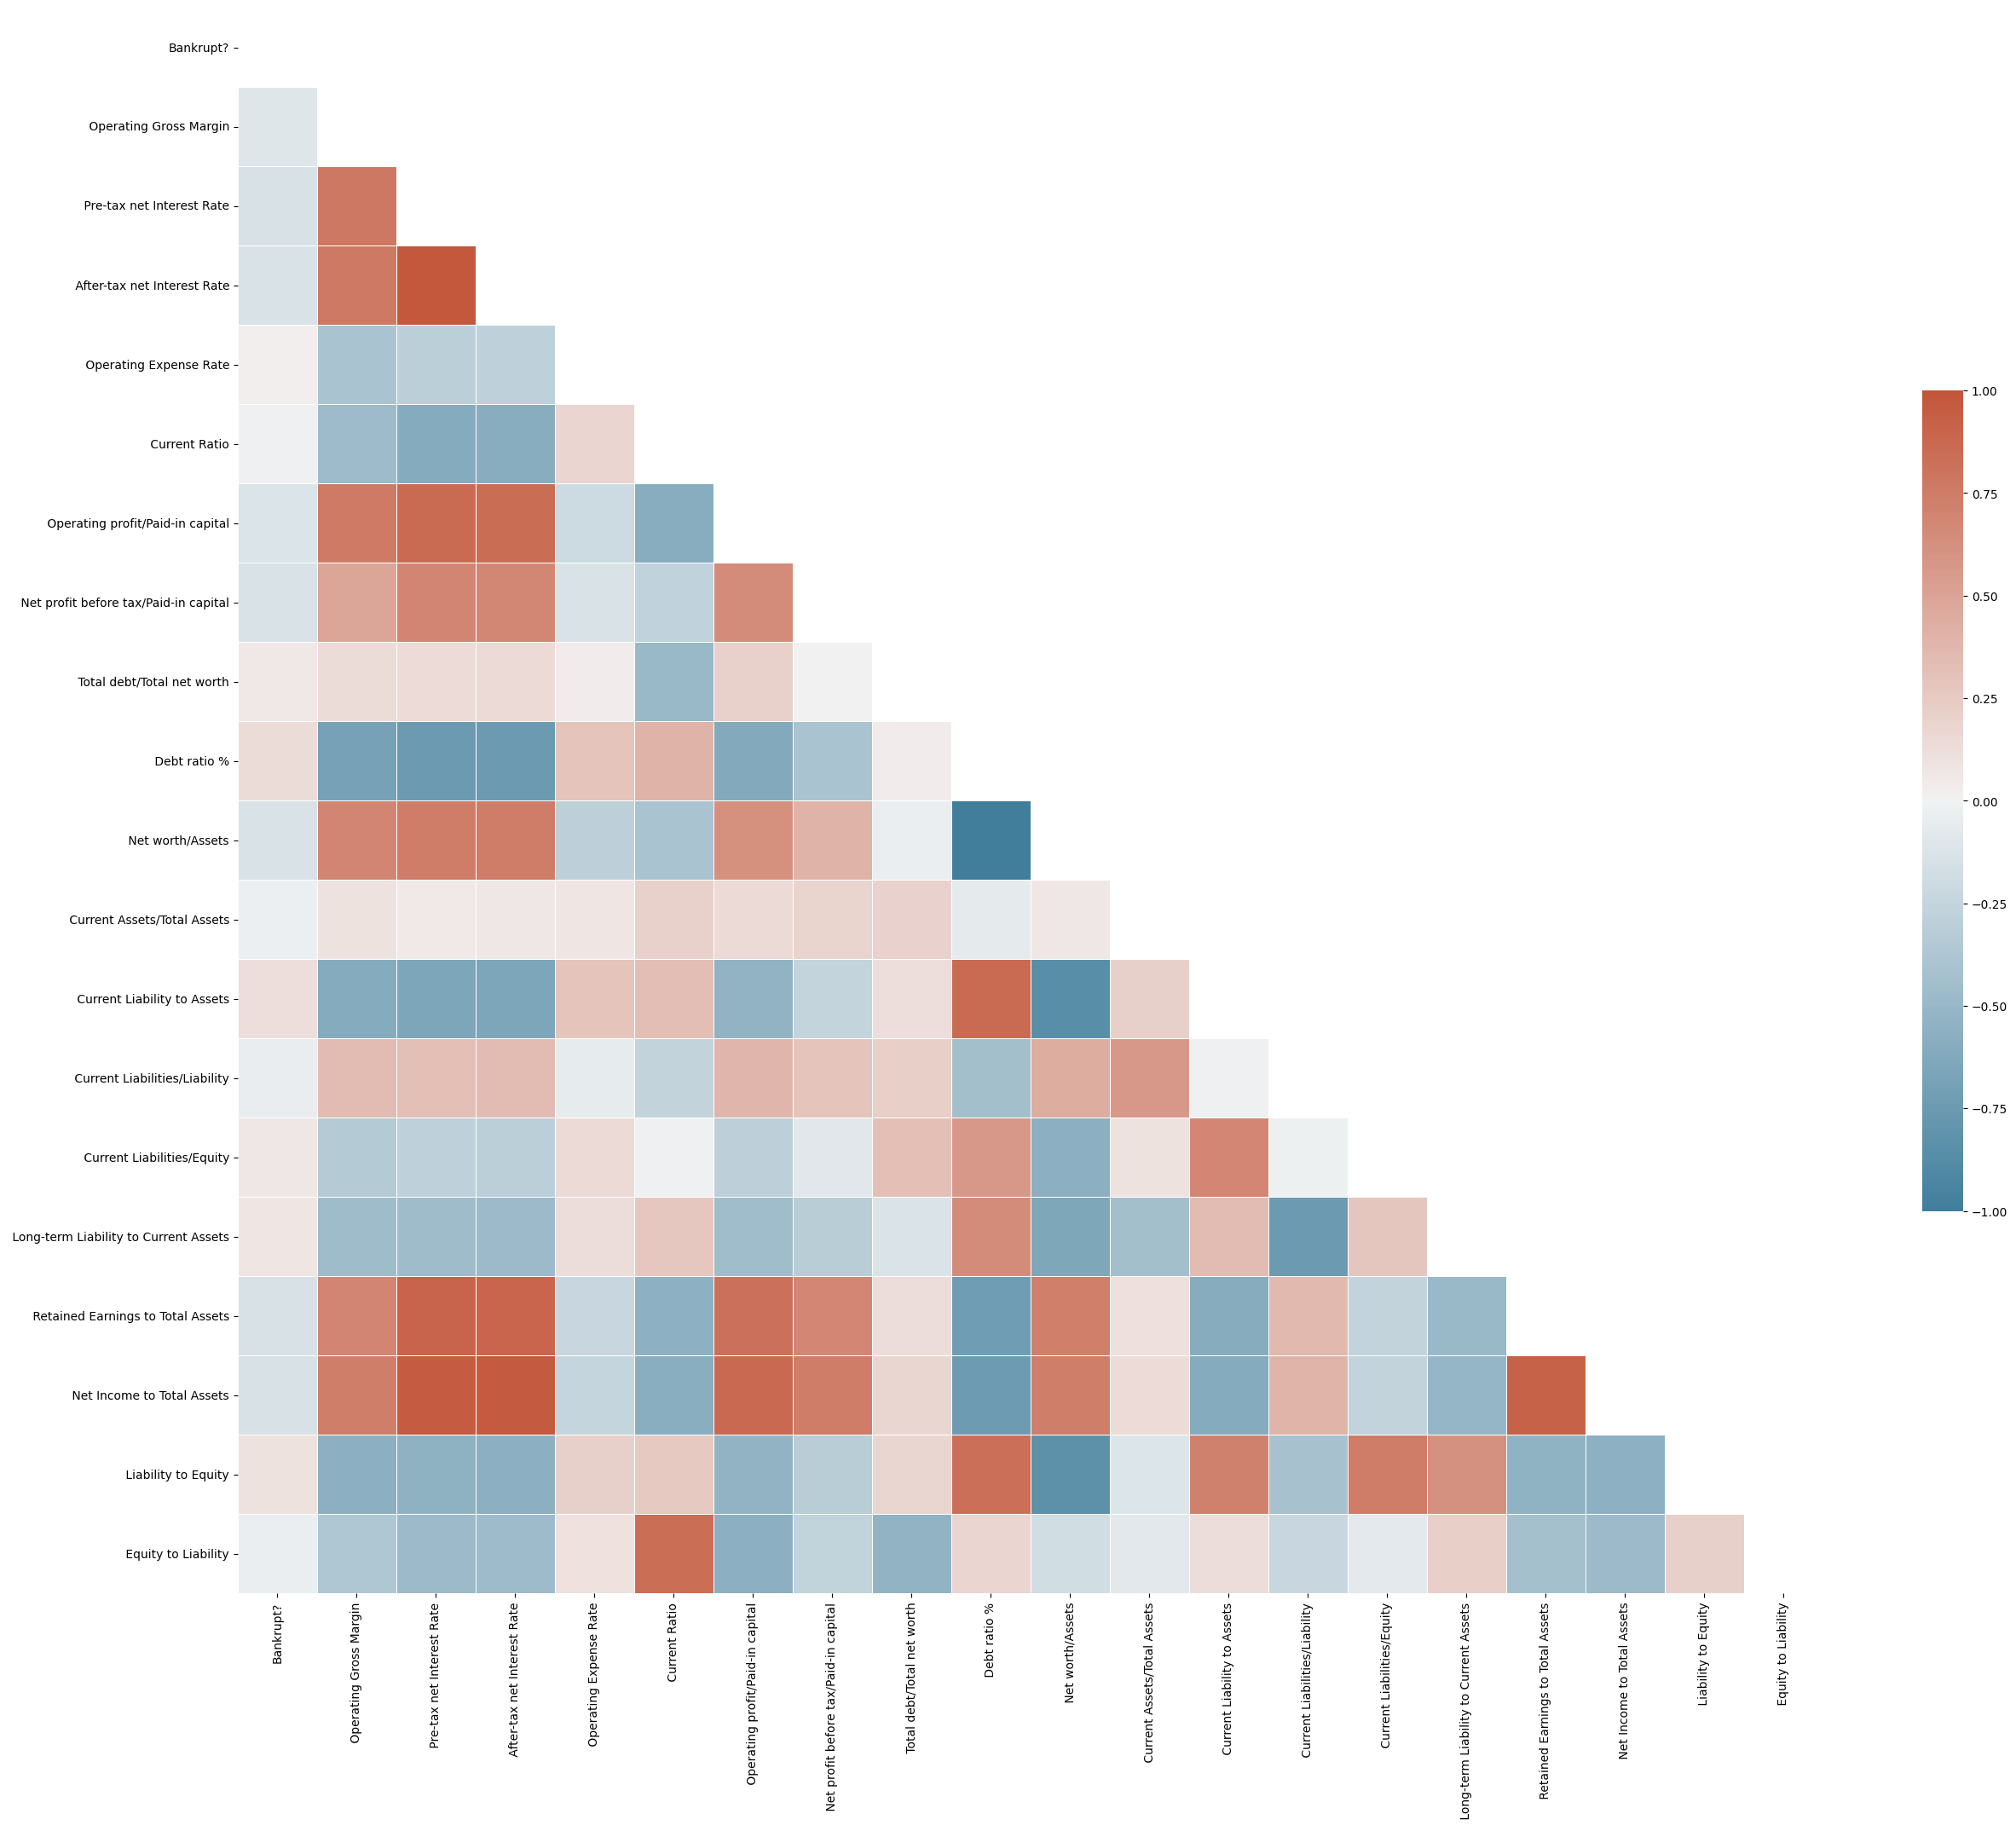

In [9]:
#Spearman Correlation Heatmap

f, ax = plt.subplots(figsize=(30, 25))
mat = atbank_data.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

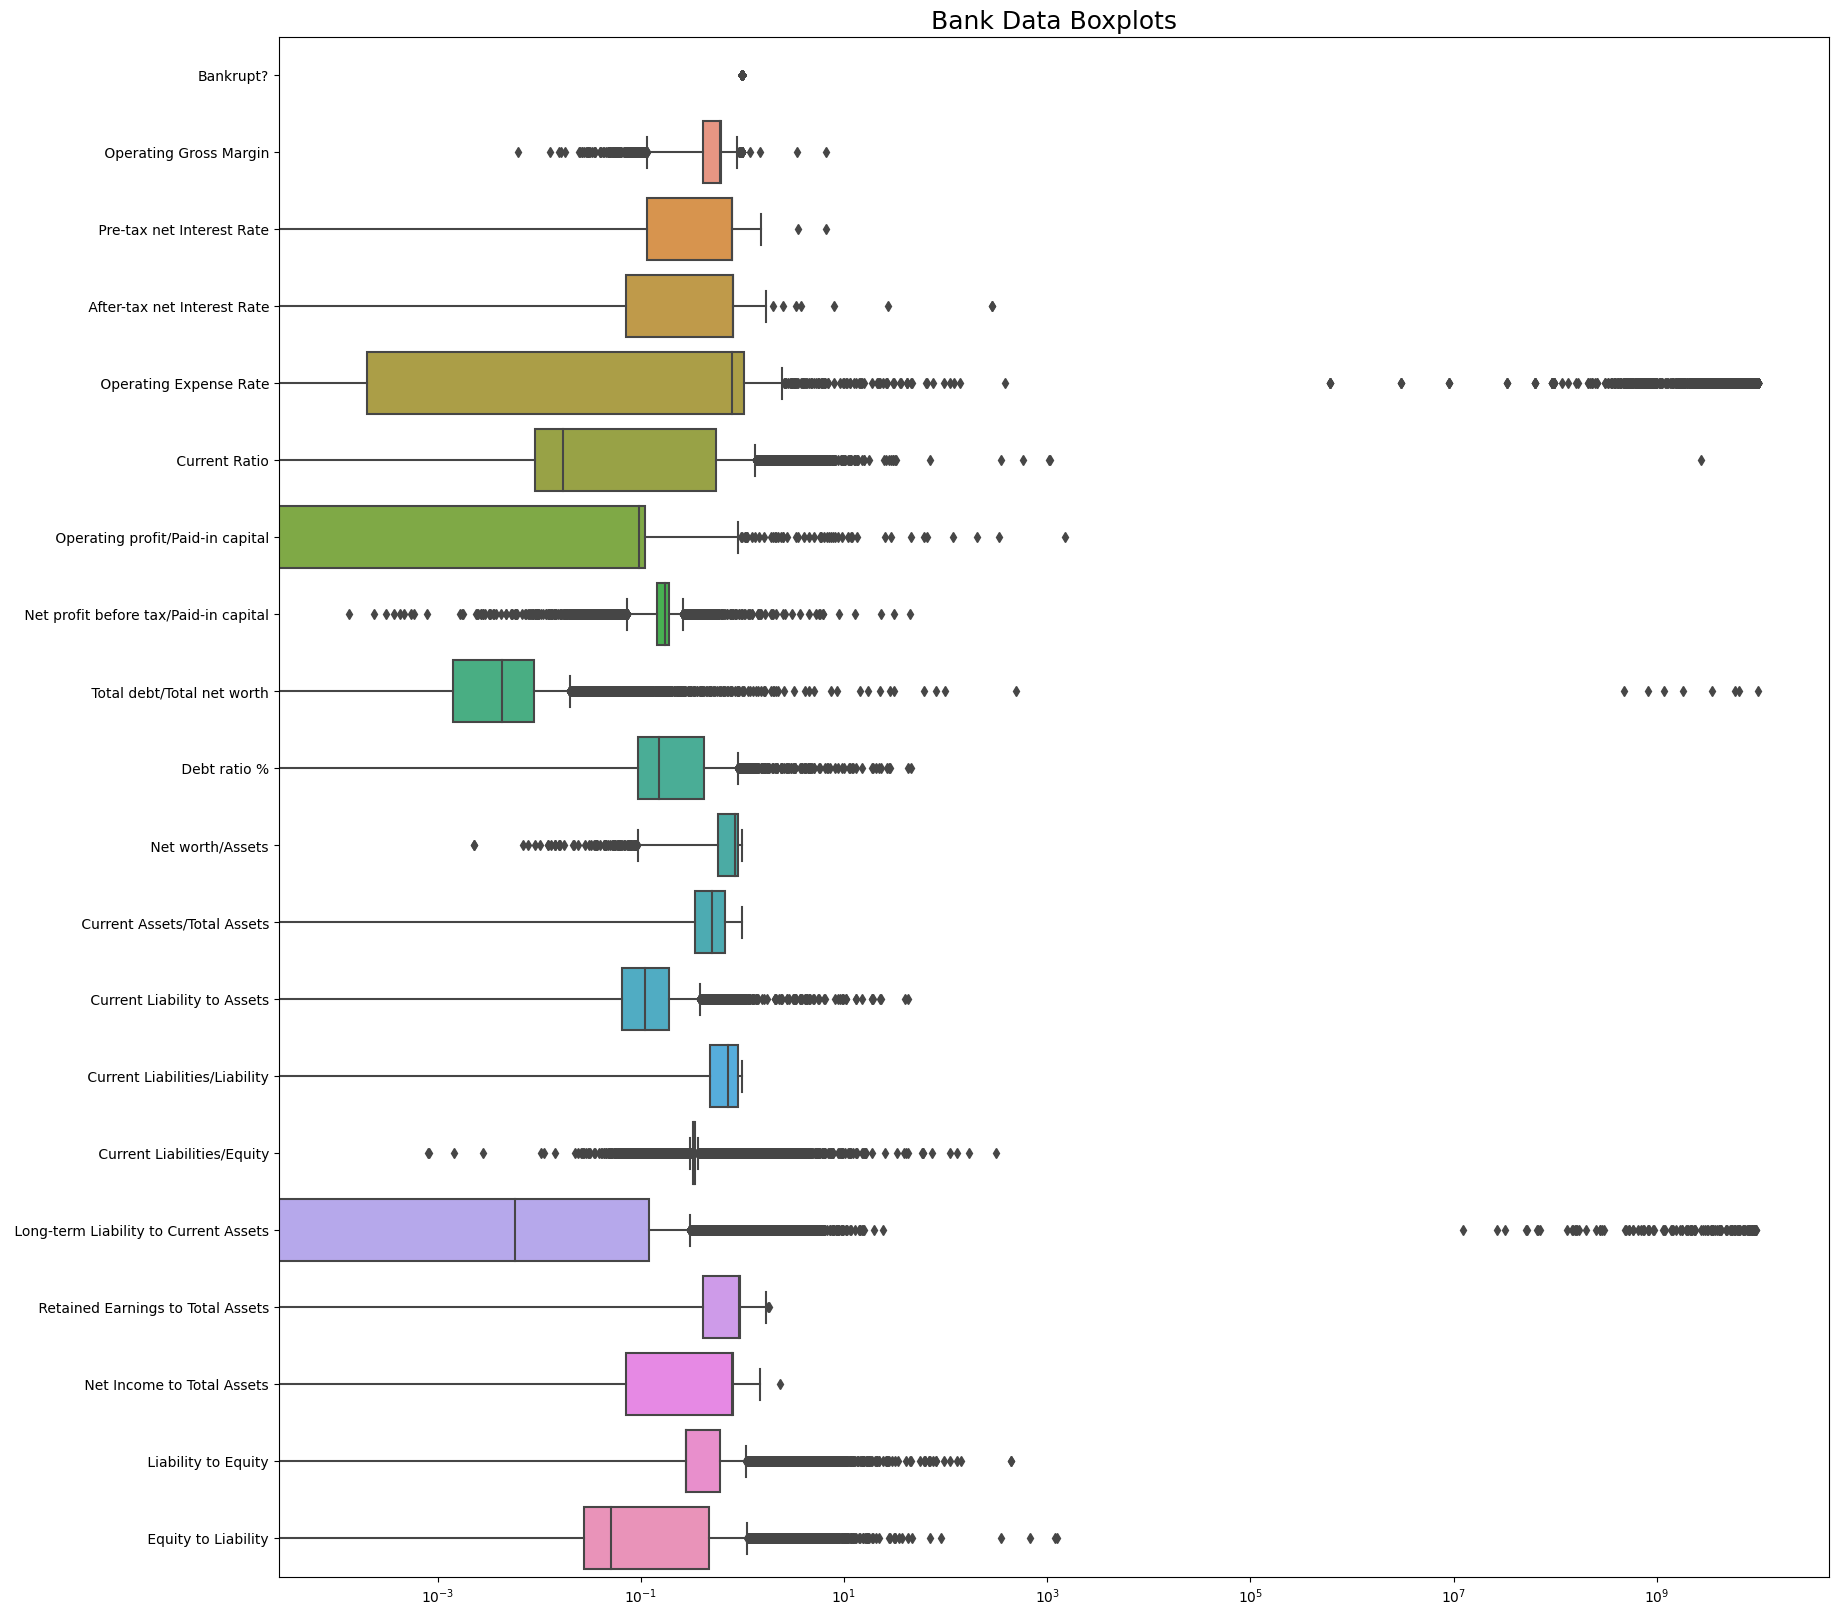

In [10]:
# Plotting Boxplots 

plt.figure(figsize = (20,20))
ax =sns.boxplot(data = atbank_data, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

In [11]:
atbank_data.columns

Index(['Bankrupt?', ' Operating Gross Margin', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate', ' Operating Expense Rate',
       ' Current Ratio', ' Operating profit/Paid-in capital',
       ' Net profit before tax/Paid-in capital', ' Total debt/Total net worth',
       ' Debt ratio %', ' Net worth/Assets', ' Current Assets/Total Assets',
       ' Current Liability to Assets', ' Current Liabilities/Liability',
       ' Current Liabilities/Equity', ' Long-term Liability to Current Assets',
       ' Retained Earnings to Total Assets', ' Net Income to Total Assets',
       ' Liability to Equity', ' Equity to Liability'],
      dtype='object')

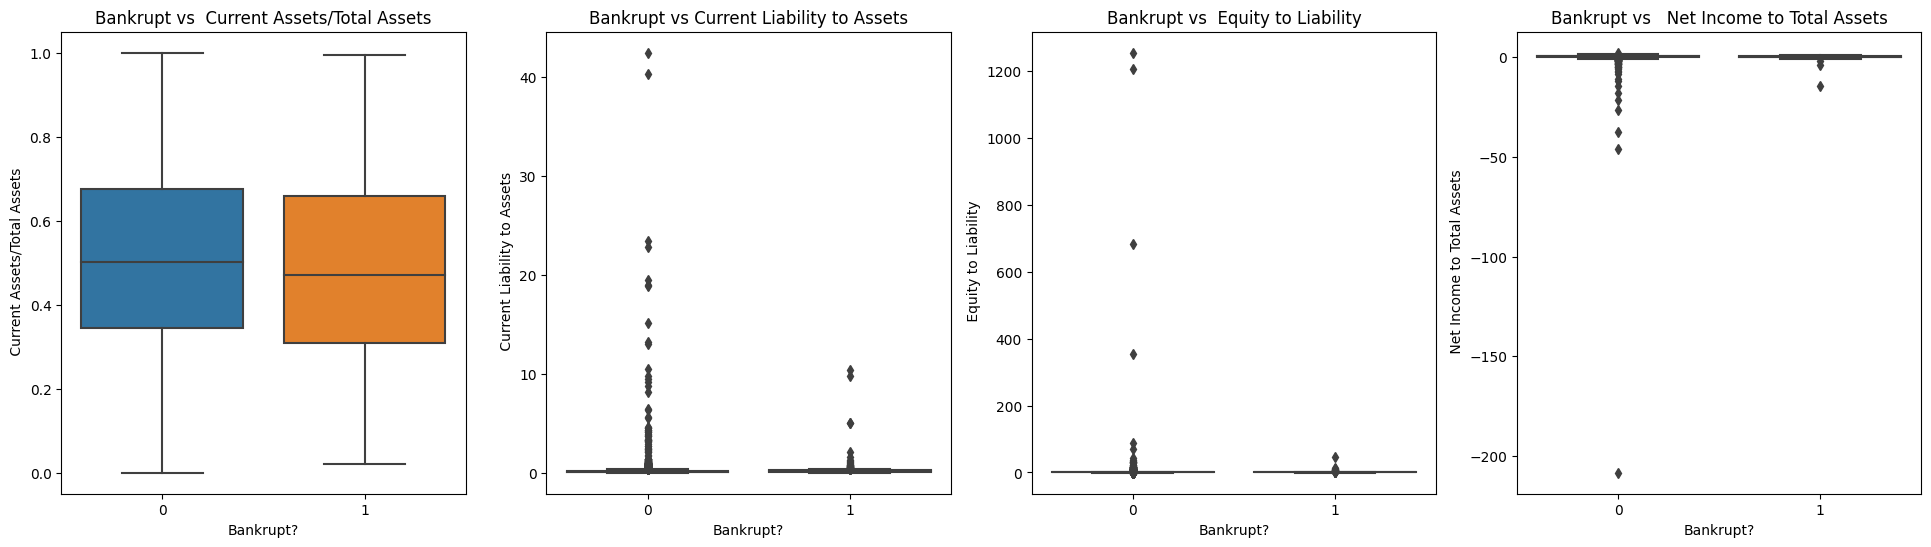

In [12]:
# Plotting other interesting features

f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt?', y=" Current Assets/Total Assets", data=atbank_data, ax=axes[0])
axes[0].set_title('Bankrupt vs  Current Assets/Total Assets')

sns.boxplot(x='Bankrupt?', y=" Current Liability to Assets", data=atbank_data, ax=axes[1])
axes[1].set_title('Bankrupt vs Current Liability to Assets')


sns.boxplot(x='Bankrupt?', y=" Equity to Liability", data=atbank_data, ax=axes[2])
axes[2].set_title('Bankrupt vs  Equity to Liability')


sns.boxplot(x='Bankrupt?', y=" Net Income to Total Assets", data=atbank_data, ax=axes[3])
axes[3].set_title('Bankrupt vs   Net Income to Total Assets')

plt.show()

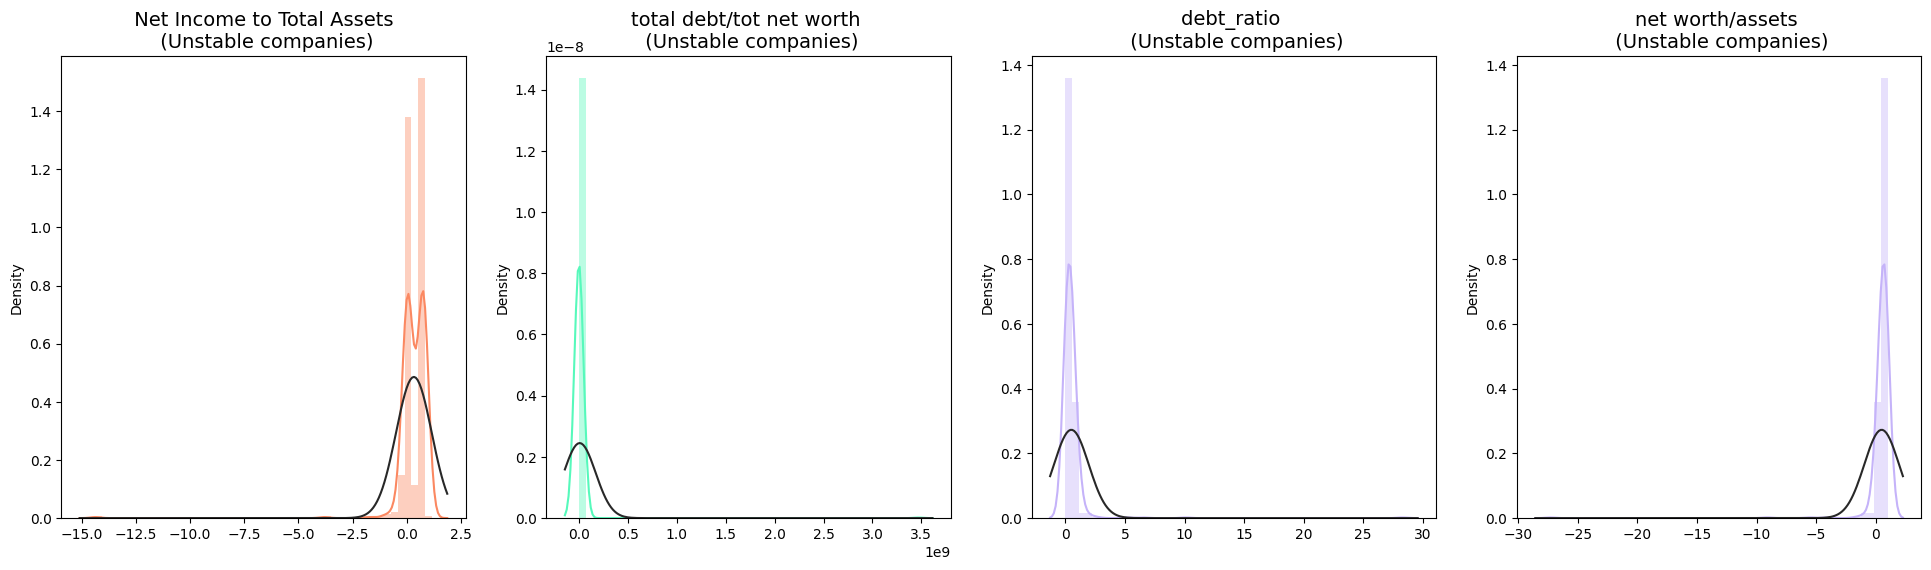

In [13]:
# Plotting the feature distributions for close to bankrputcy companies

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = atbank_data[' Net Income to Total Assets'].loc[atbank_data['Bankrupt?'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title(' Net Income to Total Assets \n (Unstable companies)', fontsize=14)

tot_debt_net = atbank_data[' Total debt/Total net worth'].loc[atbank_data['Bankrupt?'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)


debt_ratio = atbank_data[' Debt ratio %'].loc[atbank_data['Bankrupt?'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = atbank_data[' Net worth/Assets'].loc[atbank_data['Bankrupt?'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()

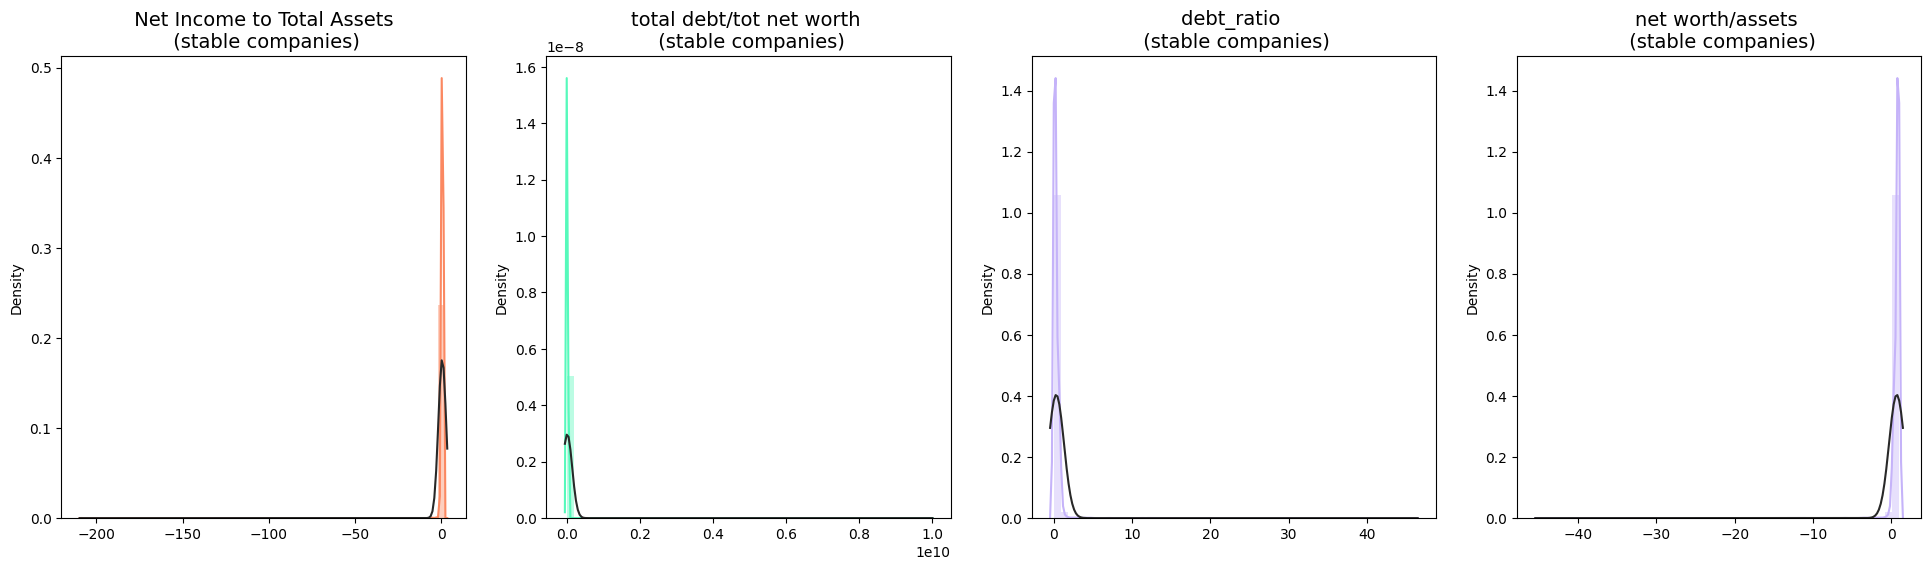

In [14]:
# Plotting the feature distributions for stable companies

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = atbank_data[' Net Income to Total Assets'].loc[atbank_data['Bankrupt?'] == 0].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title(' Net Income to Total Assets \n (stable companies)', fontsize=14)

tot_debt_net = atbank_data[' Total debt/Total net worth'].loc[atbank_data['Bankrupt?'] == 0].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (stable companies)', fontsize=14)


debt_ratio = atbank_data[' Debt ratio %'].loc[atbank_data['Bankrupt?'] == 0].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (stable companies)', fontsize=14)

net_worth_assets = atbank_data[' Net worth/Assets'].loc[atbank_data['Bankrupt?'] == 0].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (stable companies)', fontsize=14)

plt.show()

# Data pre-processing of Taiwanese data

In [15]:
# finding positive and negative corealition with the target varaible

positive_corr = atbank_data[numeric_features].corrwith(atbank_data["Bankrupt?"]).sort_values(ascending=False)[:6].index.tolist()
negative_corr = atbank_data[numeric_features].corrwith(atbank_data["Bankrupt?"]).sort_values()[:6].index.tolist()

positive_corr = atbank_data[positive_corr + ["Bankrupt?"]].copy()
negative_corr = atbank_data[negative_corr + ["Bankrupt?"]].copy()

print(negative_corr)

        Current Liabilities/Liability   Net worth/Assets   
0                            0.676269           0.792424  \
1                            0.308589           0.828824   
2                            0.446027           0.792484   
3                            0.615848           0.848535   
4                            0.975007           0.893491   
...                               ...                ...   
10557                        0.395115           0.303096   
10558                        0.815175           0.639307   
10559                        0.660114           0.630331   
10560                        0.694397           0.637876   
10561                        0.752314           0.594172   

        Operating Expense Rate   Pre-tax net Interest Rate   
0                 1.256970e-04                    0.796887  \
1                 2.897850e-04                    0.797380   
2                 2.361300e-04                    0.796403   
3                 1.078890e-04 

In [16]:
# Outliers removal 

def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

for col in atbank_data:
    bank_df = outliers_removal(atbank_data[col],str(col),atbank_data)

Quartile 25: 0.0 | Quartile 75: 0.0
iqr: 0.0
Cut Off: 0.0
Bankrupt? Lower: 0.0
Bankrupt? Upper: 0.0
Bankrupt? outliers for close to bankruptcy cases: 454
-----------------------------------------------------------------
Quartile 25: 0.41189784375000005 | Quartile 75: 0.610184638
iqr: 0.19828679424999995
Cut Off: 0.29743019137499993
 Operating Gross Margin Lower: 0.11446765237500012
 Operating Gross Margin Upper: 0.9076148293749999
 Operating Gross Margin outliers for close to bankruptcy cases: 316
-----------------------------------------------------------------
Quartile 25: 0.11483340775 | Quartile 75: 0.797505389
iqr: 0.68267198125
Cut Off: 1.024007971875
 Pre-tax net Interest Rate Lower: -0.909174564125
 Pre-tax net Interest Rate Upper: 1.821513360875
 Pre-tax net Interest Rate outliers for close to bankruptcy cases: 113
-----------------------------------------------------------------
Quartile 25: 0.0712452755 | Quartile 75: 0.8094100585
iqr: 0.738164783
Cut Off: 1.1072471744999999

In [17]:
# standardiseing features

numeric_features = bank_df.dtypes[bank_df.dtypes != 'int64'].index
bank_df[numeric_features] = bank_df[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

bank_df[numeric_features] = bank_df[numeric_features].fillna(0)

In [18]:
bank_df.describe()

Bankrupt?   Operating Gross Margin   Pre-tax net Interest Rate   
count  9107.000000             9.107000e+03                9.107000e+03  \
mean      0.038871            -2.184605e-17               -3.120864e-17   
std       0.193299             1.000000e+00                1.000000e+00   
min       0.000000            -5.850654e+01               -5.779015e+01   
25%       0.000000             5.072198e-02               -5.320446e-02   
50%       0.000000             5.894435e-02                1.090683e-01   
75%       0.000000             6.307732e-02                1.091190e-01   
max       1.000000             2.507161e-01                1.981906e-01   

        After-tax net Interest Rate   Operating Expense Rate   Current Ratio   
count                  9.107000e+03             9.107000e+03    9.107000e+03  \
mean                  -6.241728e-18            -4.993383e-17   -5.851620e-19   
std                    1.000000e+00             1.000000e+00    1.000000e+00   
min                   -7.494345e+01            -5.095317e-01   -1.047882e-02   
25%                   -2.536263e-02            -5.095317e-01   -1.047882e-02   
50%                    7.216226e-02            -5.095317e-01   -1.047882e-02   
75%                    7.218486e-02            -5.085018e-01   -1.047882e-02   
max                    2.662817e-01             2.897474e+00    9.542012e+01   

        Operating profit/Paid-in capital   
count                        9107.000000  \
mean                            0.000000   
std                             1.000000   
min                           -51.732132   
25%                             0.015874   
50%                             0.017668   
75%                             0.018285   
max                            73.510288   

        Net profit before tax/Paid-in capital   Total debt/Total net worth   
count                            9.107000e+03                 9.107000e+03  \
mean                            -2.243121e-18                -5.851620e-18   
std                              1.000000e+00                 1.000000e+00   
min                             -9.428106e+01                -2.269067e-02   
25%                              1.121514e-02                -2.269057e-02   
50%                              1.631933e-02                -2.269057e-02   
75%                              2.058681e-02                -2.269057e-02   
max                              6.442689e+00                 6.818358e+01   

        Debt ratio %   Net worth/Assets   Current Assets/Total Assets   
count   9.107000e+03       9.107000e+03                  9.107000e+03  \
mean   -1.498015e-16       2.746360e-16                 -1.685267e-16   
std     1.000000e+00       1.000000e+00                  1.000000e+00   
min    -9.131328e-01      -8.279536e+00                 -2.277845e+00   
25%    -6.131811e-01      -7.218741e-01                 -7.458473e-01   
50%    -4.433214e-01       4.433214e-01                 -4.699976e-02   
75%     7.218741e-01       6.131811e-01                  7.413331e-01   
max     8.279536e+00       9.131328e-01                  2.272816e+00   

        Current Liability to Assets   Current Liabilities/Liability   
count                  9.107000e+03                     9107.000000  \
mean                  -2.496691e-17                        0.000000   
std                    1.000000e+00                        1.000000   
min                   -9.468289e-01                       -2.681712   
25%                   -5.491085e-01                       -0.792293   
50%                   -2.900421e-01                        0.198509   
75%                    1.637627e-01                        0.902178   
max                    1.483031e+01                        1.251206   

        Current Liabilities/Equity   Long-term Liability to Current Assets   
count                 9.107000e+03                            9.107000e+03  \
mean                 -9.362592e-18                        

# Resampling of the dataset and Machine learing model implementations

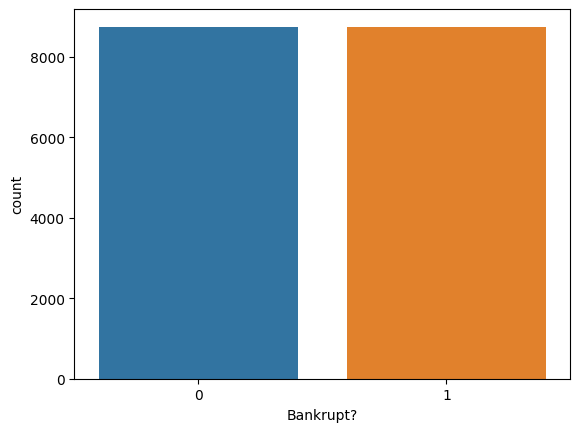

In [19]:
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE


# Separate features and target variable
X = bank_df.drop(labels=['Bankrupt?'], axis=1)
y = bank_df['Bankrupt?']

# Perform SMOTE oversampling
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Visualize the balanced class distribution
sns.countplot(x=y_resampled)

# drop national income 

# Create a DataFrame from the oversampled data
oversampled_data = pd.concat([pd.DataFrame(y_resampled, columns=['Bankrupt?']), pd.DataFrame(X_resampled, columns=X.columns)], axis=1)

# Save the oversampled data to a CSV file in the varaible ts_data
s_data = oversampled_data.to_csv('at_resampled_data.csv', index=False)

The numeric attributes have been normalized.

Our dataset is highly imbalanced. Thus before training the model, we need to deal with this data. Let us lay down some steps we must follow when we come across an imbalanced dataset.


# Machine learning model implemenations without Feature engineeirng

In [20]:
# The classes are heavily skewed we need to solve this issue later.
# count of bankrupt and non-bankrupt companies

atbank_data = pd.read_csv('at_resampled_data.csv')
print(atbank_data['Bankrupt?'].value_counts())
print('-'* 30)
print('Non-Bankrupt: ', round(atbank_data['Bankrupt?'].value_counts()[0]/len(atbank_data) * 100,2), '% of the dataset')
print('Bankrupt: ', round(atbank_data['Bankrupt?'].value_counts()[1]/len(atbank_data) * 100,2), '% of the dataset')

Bankrupt?
1    8753
0    8753
Name: count, dtype: int64
------------------------------
Non-Bankrupt:  50.0 % of the dataset
Bankrupt:  50.0 % of the dataset


# ML without hyper parameter tuning

Logistic Regression ROC-AUC: 0.77
Decision Tree ROC-AUC: 0.90
SVM ROC-AUC: 0.88
KNN ROC-AUC: 0.96
Random Forest ROC-AUC: 0.99
XGBoost ROC-AUC: 0.98
Model: Logistic Regression
              precision    recall  f1-score   support

Not Bankrupt       0.71      0.74      0.72      1773
    Bankrupt       0.72      0.69      0.70      1729

    accuracy                           0.71      3502
   macro avg       0.71      0.71      0.71      3502
weighted avg       0.71      0.71      0.71      3502

Model: Decision Tree
              precision    recall  f1-score   support

Not Bankrupt       0.92      0.87      0.90      1773
    Bankrupt       0.88      0.93      0.90      1729

    accuracy                           0.90      3502
   macro avg       0.90      0.90      0.90      3502
weighted avg       0.90      0.90      0.90      3502

Model: SVM
              precision    recall  f1-score   support

Not Bankrupt       0.92      0.67      0.77      1773
    Bankrupt       0.73      0

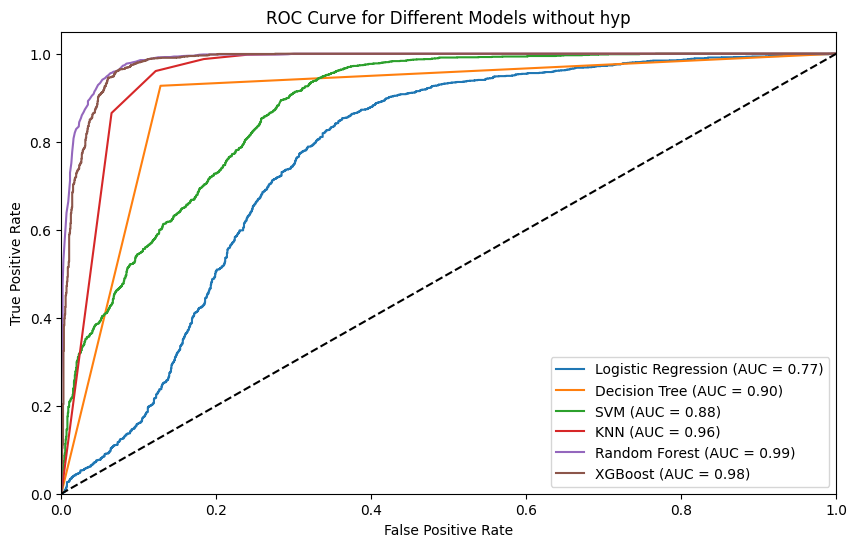

In [21]:
# without hyper parameter tuning
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report

# Load your Taiwan bankruptcy dataset (replace 'data.csv' with your file)
data = pd.read_csv('at_resampled_data.csv')

# Data preprocessing
# Handle missing values and encode categorical features if needed
# Separate features (X) and target variable (y)
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (not required for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),  # Set probability=True for SVM to enable probability estimates
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

roc_auc_scores = {}

plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[name] = roc_auc
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models without hyp')
plt.legend(loc="lower right")

# Printing ROC-AUC scores
for model_name, roc_auc in roc_auc_scores.items():
    print(f'{model_name} ROC-AUC: {roc_auc:.2f}')

# Evaluating and compare the models
for model_name in models.keys():
    y_pred = models[model_name].predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Not Bankrupt', 'Bankrupt'])
    print(f'Model: {model_name}')
    print(report)
    
plt.show()



Logistic Regression ROC-AUC: 0.77
Decision Tree ROC-AUC: 0.92
SVM ROC-AUC: 0.90
KNN ROC-AUC: 0.96
Random Forest ROC-AUC: 0.99
XGBoost ROC-AUC: 0.98
Model: Logistic Regression
              precision    recall  f1-score   support

Not Bankrupt       0.98      0.89      0.93      1773
    Bankrupt       0.90      0.98      0.94      1729

    accuracy                           0.94      3502
   macro avg       0.94      0.94      0.94      3502
weighted avg       0.94      0.94      0.94      3502

Model: Decision Tree
              precision    recall  f1-score   support

Not Bankrupt       0.98      0.89      0.93      1773
    Bankrupt       0.90      0.98      0.94      1729

    accuracy                           0.94      3502
   macro avg       0.94      0.94      0.94      3502
weighted avg       0.94      0.94      0.94      3502

Model: SVM
              precision    recall  f1-score   support

Not Bankrupt       0.98      0.89      0.93      1773
    Bankrupt       0.90      0

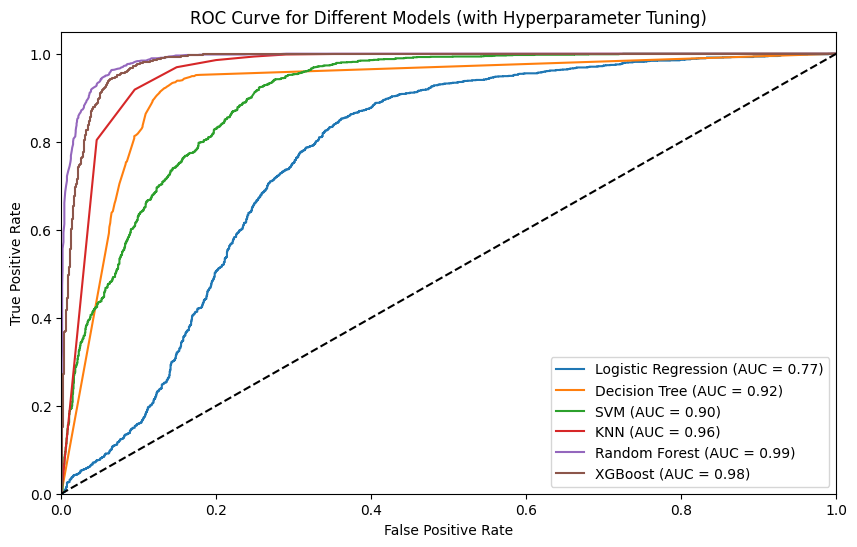

In [22]:
#with hyperparameter 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report


data = pd.read_csv('at_resampled_data.csv')

# Data preprocessing

X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and train the models with hyperparameter tuning using GridSearchCV
models = {
    'Logistic Regression': (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    'XGBoost': (XGBClassifier(), {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}),
}

roc_auc_scores = {}

plt.figure(figsize=(10, 6))

for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probability of positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[name] = roc_auc
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models (with Hyperparameter Tuning)')
plt.legend(loc="lower right")

# ROC-AUC scores
for model_name, roc_auc in roc_auc_scores.items():
    print(f'{model_name} ROC-AUC: {roc_auc:.2f}')

# compare the models
for model_name, (model, _) in models.items():
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Not Bankrupt', 'Bankrupt'])
    print(f'Model: {model_name}')
    print(report)
    
plt.show()


# Plotting important Features using PCA

In [23]:
from sklearn.decomposition import PCA
import plotly.express as px

def preprocess_inputs(df):
    df = df.copy()
    
    # Remove leading/trailing spaces from column names
    df.columns = df.columns.str.strip()
    
    # split data into x and y
    X = df.drop('Bankrupt?', axis=1) 
    Y = df['Bankrupt?']
    

   # train test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, shuffle=True, random_state=1)

    # Store the original index values
    X_train_index = X_train.index
    X_test_index = X_test.index

    # Scale x
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train_index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test_index, columns=X_test.columns)

    
    
    return X_train, X_test, Y_train, Y_test

In [24]:
X_train, X_test, Y_train, Y_test = preprocess_inputs(data)

In [25]:

n_components = 12

pca = PCA(n_components=n_components)
pca.fit(X_train)

X_train_reduced = pd.DataFrame(pca.transform(X_train), index=X_train.index, columns=["PC" + str(i) for i in range(1, n_components + 1)])
X_test_reduced = pd.DataFrame(pca.transform(X_test), index=X_test.index, columns=["PC" + str(i) for i in range(1, n_components + 1)])

In [26]:
# Assuming you have already performed PCA and have X_train_reduced with 12 principal components


top_10_components = 10
loadings = pca.components_[:top_10_components]

# Creating a DataFrame to display the results
loadings_df = pd.DataFrame(loadings, columns=X_train.columns)
loadings_df = loadings_df.abs()  # Take absolute values for importance

# Displaying the first 10 important features
print("Top 10 Important Features:")
print(loadings_df.iloc[:, :top_10_components])


Top 10 Important Features:
   Operating Gross Margin  Pre-tax net Interest Rate   
0                0.248209                   0.306370  \
1                0.458120                   0.423968   
2                0.186138                   0.162852   
3                0.101191                   0.074394   
4                0.002981                   0.002081   
5                0.004613                   0.003224   
6                0.011813                   0.006435   
7                0.040730                   0.003597   
8                0.110553                   0.049278   
9                0.208684                   0.091167   

   After-tax net Interest Rate  Operating Expense Rate  Current Ratio   
0                     0.305205                0.138524       0.003671  \
1                     0.423207                0.141959       0.002478   
2                     0.166853                0.000317       0.003635   
3                     0.065564                0.086554       0.0

In [27]:
fig = px.bar(
    x=["PC" + str(i) for i in range(1, n_components + 1)],
    y=pca.explained_variance_ratio_,
    labels={'x': "Principal Component", 'y': "Variance Ratio"},
    color=pca.explained_variance_ratio_,
    color_continuous_scale=[(0, 'lightblue'), (1, 'darkblue')],
    title="Proportion of Variance in Principal Components"
)

fig.show()

# Machine learning model implemenations in Spark

In [28]:
# without feature engineeirng
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize a Spark session
spark = SparkSession.builder.appName("ml_sparkat").getOrCreate()


df = spark.read.csv("at_resampled_data.csv", header=True, inferSchema=True)

# Select the features (excluding the label column)
feature_cols = [col_name for col_name in df.columns if col_name != 'Bankrupt?']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df)

# StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Fitting and transform the scaler
scaler_model = scaler.fit(df_assembled)
scaled_data = scaler_model.transform(df_assembled)

# training and testing sets
train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=42)


dt_classifier = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="Bankrupt?", maxDepth=5)
dt_model = dt_classifier.fit(train_data)
predictions = dt_model.transform(test_data)

# Evaluations
evaluator = MulticlassClassificationEvaluator(labelCol="Bankrupt?", predictionCol="prediction", metricName="f1")
dt_f1_score = evaluator.evaluate(predictions)
print(f"F1 Score of Decision Tree: {f1_score}")


F1 Score of Decision Tree: <function f1_score at 0x000001B8D9A4F920>


In [29]:
# 2. logistic regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='scaled_features', labelCol='Bankrupt?')
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Bankrupt?", predictionCol="prediction", metricName="f1")
lr_f1_score = evaluator.evaluate(lr_predictions)

print("Logistic Regression F1 Score:", lr_f1_score)

Logistic Regression F1 Score: 0.6981552196240037


In [30]:
# 3. SVM

from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an instance of the LinearSVC model
svm = LinearSVC(featuresCol='scaled_features', labelCol='Bankrupt?', maxIter=100)

# Fit the SVM model to the training data
svm_model = svm.fit(train_data)

# Make predictions on the test data
svm_predictions = svm_model.transform(test_data)

# Evaluate the SVM model
evaluator = MulticlassClassificationEvaluator(labelCol="Bankrupt?", predictionCol="prediction", metricName="f1")
svm_f1_score = evaluator.evaluate(svm_predictions)

print("SVM F1 Score:", svm_f1_score)

SVM F1 Score: 0.7422839492418434


In [31]:
# 4. xg boost
from pyspark.ml.classification import LinearSVC, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

xgboost = GBTClassifier(featuresCol='scaled_features', labelCol='Bankrupt?', maxDepth=5, maxIter=50)

# Fit the XGBoost model to the training data
xgboost_model = xgboost.fit(train_data)

# Make predictions on the test data using XGBoost
xgboost_predictions = xgboost_model.transform(test_data)

# Evaluate the XGBoost model
xgboost_f1_score = evaluator.evaluate(xgboost_predictions)

print("XGBoost F1 Score:", xgboost_f1_score)

spark.stop()

XGBoost F1 Score: 0.8929893347879552


In [32]:
#5.
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize a Spark session
spark = SparkSession.builder.appName("sparkat").getOrCreate()

# Load the CSV data into a Spark DataFrame
df = spark.read.csv("at_resampled_data.csv", header=True, inferSchema=True)

# Select the features for scaling 
feature_cols = [col_name for col_name in df.columns if col_name != 'Bankrupt?']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df)

# Initializing the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Fit and transform the scaler
scaler_model = scaler.fit(df_assembled)
scaled_data = scaler_model.transform(df_assembled)

# Split the data into training and testing sets
train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=42)

# Create an instance of the RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='Bankrupt?', numTrees=100, maxDepth=5)

# Fit the Random Forest model to the training data
rf_model = rf.fit(train_data)

# Make predictions on the test data using Random Forest
rf_predictions = rf_model.transform(test_data)

# Evaluate the Random Forest model using F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="Bankrupt?", predictionCol="prediction", metricName="f1")
rf_f1_score = evaluator.evaluate(rf_predictions)

print("Random Forest F1 Score:", rf_f1_score)

# Stop the Spark session when done
spark.stop()


Random Forest F1 Score: 0.8259644949993958


# plotting graph without feature engg.

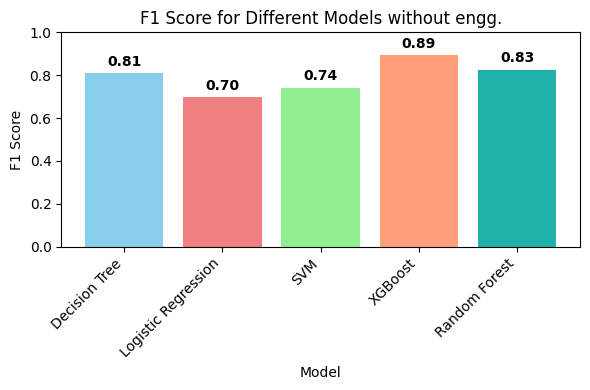

In [33]:
import matplotlib.pyplot as plt

# F1 scores for different models
model_names = ["Decision Tree", "Logistic Regression", "SVM", "XGBoost", "Random Forest"]
f1_scores = [dt_f1_score, lr_f1_score, svm_f1_score, xgboost_f1_score, rf_f1_score]


colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen']


#plots
plt.figure(figsize=(6, 4))  
plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Models without engg.')
plt.ylim(0, 1) 
plt.xticks(rotation=45, ha="right") 


for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')


plt.tight_layout()
plt.show()



In [34]:
# with feature eengiineering
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initializing Spark session
spark = SparkSession.builder.appName("ML_with_pca").getOrCreate()

# Load the data
df = spark.read.csv("at_resampled_data.csv", header=True, inferSchema=True)

# Selecting the features for scaling
feature_cols = [col_name for col_name in df.columns if col_name != 'Bankrupt?']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df)

# StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Fit and transform the scaler
scaler_model = scaler.fit(df_assembled)
scaled_data = scaler_model.transform(df_assembled)

# Apply PCA
num_pca_components = 15
pca = PCA(k=num_pca_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
X_pca = pca_model.transform(scaled_data).select("pca_features", "Bankrupt?")

# Split the data into training and testing sets
train_data, test_data = X_pca.randomSplit([0.8, 0.2], seed=42)

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="pca_features", labelCol="Bankrupt?", maxDepth=5)

# Fit the model
dt_model = dt_classifier.fit(train_data)

# Make predictions on the test data
predictions = dt_model.transform(test_data)

# Evaluate the model using F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="Bankrupt?", predictionCol="prediction", metricName="f1")
dtf_f1_score = evaluator.evaluate(predictions)
print(f"F1 Score of Decision tree: {dtf_f1_score}")

F1 Score of Decision tree: 0.7785810557813628


In [35]:
# 2. logistic regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='pca_features', labelCol='Bankrupt?')
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Bankrupt?", predictionCol="prediction", metricName="f1")
lrf_f1_score = evaluator.evaluate(lr_predictions)

print("Logistic Regression F1 Score:", lrf_f1_score)



Logistic Regression F1 Score: 0.6877586935203557


In [36]:
# 3. SVM

from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an instance of the LinearSVC model
svm = LinearSVC(featuresCol='pca_features', labelCol='Bankrupt?', maxIter=100)

# Fit the SVM model to the training data
svm_model = svm.fit(train_data)

# Make predictions on the test data
svm_predictions = svm_model.transform(test_data)

# Evaluate the SVM model
evaluator = MulticlassClassificationEvaluator(labelCol="Bankrupt?", predictionCol="prediction", metricName="f1")
svmf_f1_score = evaluator.evaluate(svm_predictions)

print("SVM F1 Score:", svmf_f1_score)

SVM F1 Score: 0.7032490505653333


In [37]:
# 4. xg boost
from pyspark.ml.classification import LinearSVC, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

xgboost = GBTClassifier(featuresCol='pca_features', labelCol='Bankrupt?', maxDepth=5, maxIter=50)

# Fit the XGBoost model to the training data
xgboost_model = xgboost.fit(train_data)

# Make predictions on the test data using XGBoost
xgboost_predictions = xgboost_model.transform(test_data)

# Evaluate the XGBoost model
xgboostf_f1_score = evaluator.evaluate(xgboost_predictions)

print("XGBoost F1 Score:", xgboostf_f1_score)



XGBoost F1 Score: 0.8650992749635382


In [38]:
from pyspark.ml.classification import RandomForestClassifier

# Create an instance of the RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='pca_features', labelCol='Bankrupt?', numTrees=100, maxDepth=5)

# Fit the Random Forest model to the training data
rf_model = rf.fit(train_data)

# Make predictions on the test data using Random Forest
rf_predictions = rf_model.transform(test_data)

# Evaluate the Random Forest model using F1 score
rff_f1_score = evaluator.evaluate(rf_predictions)

print("Random Forest F1 Score:", rff_f1_score)

spark.stop()

Random Forest F1 Score: 0.7714331950862252


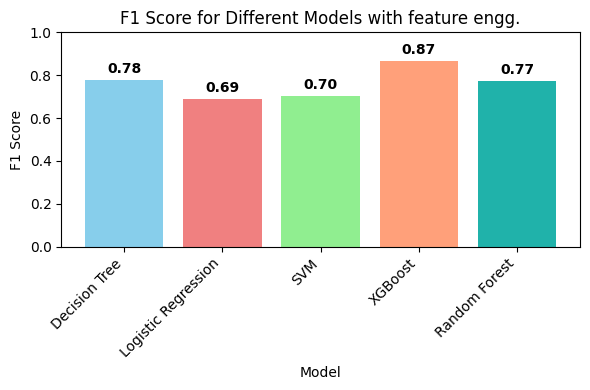

In [39]:
import matplotlib.pyplot as plt

# F1 scores for different models
model_names = ["Decision Tree", "Logistic Regression", "SVM", "XGBoost", "Random Forest"]
f1_scores = [dtf_f1_score, lrf_f1_score, svmf_f1_score, xgboostf_f1_score, rff_f1_score]

# Define custom colors for the bars
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen']

# Create a bar plot for F1 scores
plt.figure(figsize=(6, 4))  # Set the figure size to make it smaller
plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Models with feature engg.')
plt.ylim(0, 1)  # Set the y-axis range (0 to 1)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability

# Add labels to the bars
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


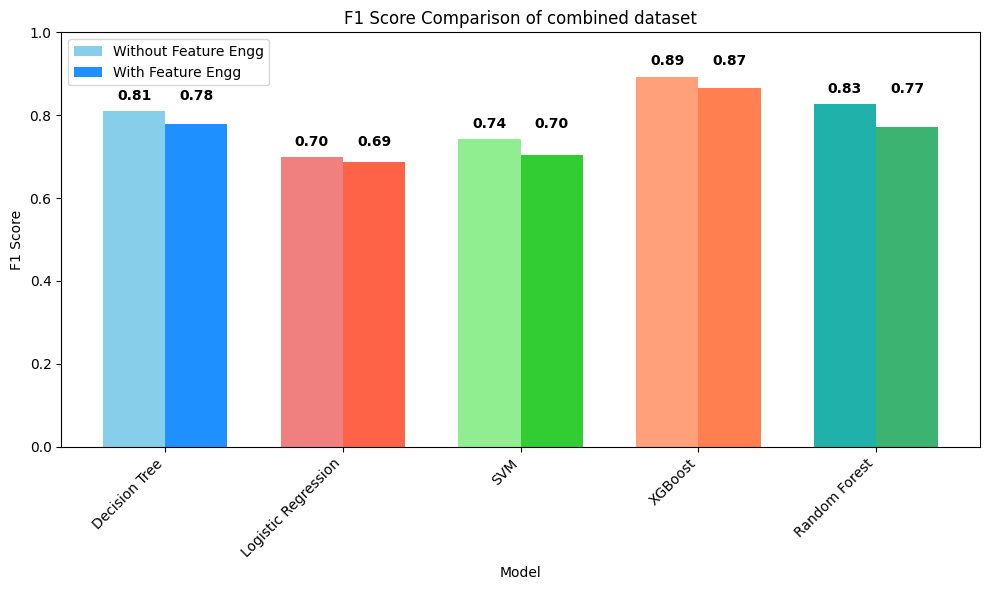

In [40]:
# percentage change graph of f1 score with feature engineering and without feature engg


import matplotlib.pyplot as plt
import numpy as np

# Model names
model_names = ["Decision Tree", "Logistic Regression", "SVM", "XGBoost", "Random Forest"]

# F1 scores without feature engineering
f1_scores_without_feature_engg = [dt_f1_score, lr_f1_score, svm_f1_score, xgboost_f1_score, rf_f1_score]

# F1 scores with feature engineering
f1_scores_with_feature_engg = [dtf_f1_score, lrf_f1_score, svmf_f1_score, xgboostf_f1_score, rff_f1_score]

# Define custom colors for bars
colors_without_feature_engg = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen']
colors_with_feature_engg = ['dodgerblue', 'tomato', 'limegreen', 'coral', 'mediumseagreen']

# Create x-axis positions for bars
x = np.arange(len(model_names))

# Set the width of the bars
bar_width = 0.35

# Create a properly sized figure
plt.figure(figsize=(10, 6))

# Create a bar plot for F1 scores with and without feature engineering
plt.bar(x - bar_width/2, f1_scores_without_feature_engg, bar_width, label='Without Feature Engg', color=colors_without_feature_engg)
plt.bar(x + bar_width/2, f1_scores_with_feature_engg, bar_width, label='With Feature Engg', color=colors_with_feature_engg)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison of combined dataset')
plt.ylim(0, 1)  # Set the y-axis range (0 to 1)
plt.xticks(x, model_names, rotation=45, ha="right")  # Rotate x-axis labels for readability

# Add labels to the bars without overlapping
for i, (v1, v2) in enumerate(zip(f1_scores_without_feature_engg, f1_scores_with_feature_engg)):
    plt.text(x[i] - bar_width/2, max(v1, v2) + 0.02, f"{v1:.2f}", ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')
    plt.text(x[i] + bar_width/2, max(v1, v2) + 0.02, f"{v2:.2f}", ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')

# Add a legend
plt.legend(loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()



# size up and scale up and speed up

In [41]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler
import time

# Initialize a Spark session
spark = SparkSession.builder.appName("metrics").getOrCreate()

tbank_data = spark.read.csv("at_resampled_data.csv", header=True, inferSchema=True)

# Selecting features and target column
feature_cols = [col_name for col_name in tbank_data.columns if col_name != 'Bankrupt?']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
tbank_data = assembler.transform(tbank_data).select("features", "Bankrupt?")

# Splitting the dataset
train_data, test_data = tbank_data.randomSplit([0.8, 0.2], seed=42)

# Repartitioning the train_data and test_data into 4 partitions
train_data = train_data.repartition(4)
test_data = test_data.repartition(4)

# Initialize the parameters
m_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Dataset size factors

# Function to measure execution time
def measure_time(model, data):
    start_time = time.time()
    model.fit(data)
    end_time = time.time()
    return end_time - start_time

models = {
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol="Bankrupt?"),
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="Bankrupt?"),
    "XGBoost": GBTClassifier(featuresCol="features", labelCol="Bankrupt?")
}

for model_name, model in models.items():
    # Lists to store metrics
    sizeups = []
    speedups = []
    scaleups = []

    # Time for base dataset
    T1 = measure_time(model, train_data)
    base_count = train_data.count()

    for m in m_values:
        fraction = min(m * base_count / tbank_data.count(), 1.0)  # Cap fraction to 1.0
        other_fraction = 1 - fraction
        subset_data, _ = tbank_data.randomSplit([fraction, other_fraction], seed=42)

        # Maintain data in 4 partitions
        subset_data = subset_data.repartition(4)

        Tm = measure_time(model, subset_data)  # Time for m partitions

        # Calculate metrics
        sizeups.append(Tm / T1)
        speedups.append(T1 / Tm)
        scaleups.append((T1 / Tm) / m)

    # Print results
    print(f"{model_name}")
    print("Sizeups:", sizeups)
    print("Speedups:", speedups)
    print("Scaleups:", scaleups)
    print("\n")

spark.stop()



Decision Tree
Sizeups: [0.8003103066927882, 0.8465291571450697, 0.883981345368813, 0.7860764137024044, 0.7488401540121133, 0.7115861418081659, 0.7355793886070526, 0.7496288728331291, 0.7526580313368095]
Speedups: [1.2495153337864806, 1.181294219531094, 1.131245591594223, 1.2721409554702445, 1.3353984754185921, 1.4053112353466637, 1.35947256745961, 1.3339934416088115, 1.3286246321239432]
Scaleups: [12.495153337864805, 5.90647109765547, 3.7708186386474103, 3.1803523886756113, 2.6707969508371843, 2.34218539224444, 1.942103667799443, 1.6674918020110143, 1.4762495912488258]


Random Forest
Sizeups: [0.8353476054186119, 0.8681102576476095, 0.8776913539239878, 0.9137105959397684, 0.962758506039023, 0.9124807574894473, 0.9059359125031872, 0.9621578527419774, 1.0067495157006021]
Speedups: [1.1971064422922204, 1.1519274092092668, 1.1393526842086275, 1.094438440840758, 1.0386820721160863, 1.0959135212356133, 1.1038308407897253, 1.0393304977454367, 0.9932957348423405]
Scaleups: [11.971064422922204

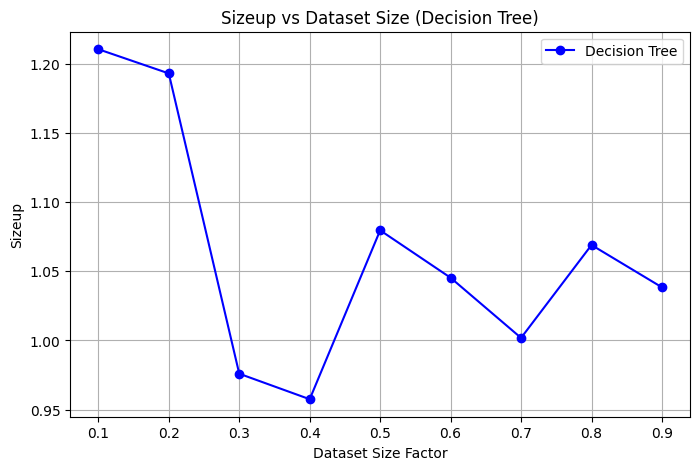

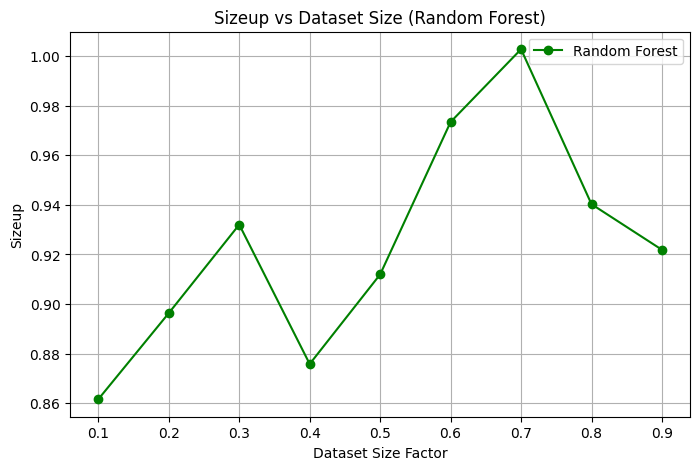

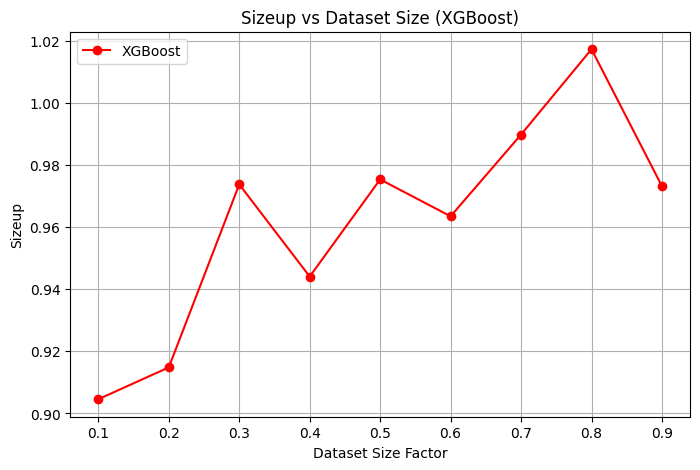

In [42]:
# plotting graph for size up metrics
import matplotlib.pyplot as plt


# Arrays for sizeup metrics for Decision Tree, Random Forest, and XGBoost
sizeups_dt = [1.21042492067979, 1.1929415532949137, 0.9759720036416256, 0.9575408531879324, 1.0795707079833088, 1.0452960603016768, 1.0018463081510334, 1.0689735576197155, 1.0383850905233079]
sizeups_rf = [0.8616188718128243, 0.8963454705990818, 0.9320296946269455, 0.8758221664558782, 0.9119466761287651, 0.9734160696174525, 1.0027545994946465, 0.9402635276852787, 0.9218742691963828]
sizeups_xgb = [0.90456680115891, 0.9148178616015123, 0.9737396572100233, 0.9440651465430865, 0.9753343497322666, 0.9634632850010106, 0.9897813734605104, 1.0172620098311105, 0.9731486735788968]

# Plotting sizeup metrics for Decision Tree
plt.figure(figsize=(8, 5))
plt.plot(m_values, sizeups_dt, marker='o', linestyle='-', color='blue', label='Decision Tree')
plt.xlabel('Dataset Size Factor')
plt.ylabel('Sizeup')
plt.title('Sizeup vs Dataset Size (Decision Tree)')
plt.xticks(m_values)
plt.grid()
plt.legend()
plt.show()

# Plotting sizeup metrics for Random Forest
plt.figure(figsize=(8, 5))
plt.plot(m_values, sizeups_rf, marker='o', linestyle='-', color='green', label='Random Forest')
plt.xlabel('Dataset Size Factor')
plt.ylabel('Sizeup')
plt.title('Sizeup vs Dataset Size (Random Forest)')
plt.xticks(m_values)
plt.grid()
plt.legend()
plt.show()

# Plotting sizeup metrics for XGBoost
plt.figure(figsize=(8, 5))
plt.plot(m_values, sizeups_xgb, marker='o', linestyle='-', color='red', label='XGBoost')
plt.xlabel('Dataset Size Factor')
plt.ylabel('Sizeup')
plt.title('Sizeup vs Dataset Size (XGBoost)')
plt.xticks(m_values)
plt.grid()
plt.legend()
plt.show()


# References:
1. https://www.kaggle.com/code/marto24/bankruptcy-detection
2. https://www.sciencedirect.com/science/article/pii/S1877050917327345

In [ ]:
END